In [37]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict

In [38]:
API_URL = "http://localhost:8000"

def get_versions():
    response = requests.get(f"{API_URL}/versions")
    return response.json()

def get_schema_timestamps(version):
    response = requests.get(f"{API_URL}/archive/schema/{version}")
    return response.json()

def get_schema_data(version, timestamp):
    response = requests.get(f"{API_URL}/archive/schema/{version}/{timestamp}")
    return response.json()

In [39]:
get_versions()

{'versions': ['v1.0']}

In [40]:
get_schema_timestamps("v1.0")

[2, 1, 0]

In [41]:
get_schema_data("v1.0", 0)


{'metadata': {'node_types': {'BusinessUnit': ['id',
    'name',
    'description',
    'revenue',
    'node_type'],
   'ProductFamily': ['id', 'name', 'revenue', 'node_type'],
   'ProductOffering': ['id', 'name', 'cost', 'demand', 'node_type'],
   'Facility': ['id',
    'name',
    'type',
    'location',
    'max_capacity',
    'operating_cost',
    'node_type'],
   'Supplier': ['id', 'name', 'location', 'reliability', 'size', 'node_type'],
   'Warehouse': ['id',
    'name',
    'type',
    'size',
    'location',
    'max_capacity',
    'current_capacity',
    'safety_stock',
    'node_type'],
   'Parts': ['id',
    'name',
    'description',
    'type',
    'cost',
    'importance',
    'level',
    'units_in_chain',
    'expected_life',
    'node_type']},
  'keys': {'links': ['source', 'target', 'key']}},
 'data': {'nodes': {'BusinessUnit': [['1',
     'BU_9388',
     'Business Unit 1',
     3909335.14,
     'BusinessUnit'],
    ['2', 'BU_4891', 'Business Unit 2', 4582824.29, 'Busi

In [42]:
def decompress_graph_json(compressed_data: Dict) -> Dict: # Can be found in utils/compression.py
    decompressed = {"nodes": {}, "links": []}

    # Decompress nodes
    for node_type, template_keys in compressed_data["metadata"]["node_types"].items():
        decompressed["nodes"][node_type] = {}

        for node_array in compressed_data["data"]["nodes"].get(node_type, []):
            # Create node data using all values (including ID) with their corresponding keys
            node_data = dict(zip(template_keys, node_array))
            node_id = node_array[0]  # First value is always the ID
            decompressed["nodes"][node_type][node_id] = node_data

    # Decompress links
    link_template = compressed_data["metadata"]["keys"]["links"]
    decompressed["links"] = [
        dict(zip(link_template, link_data))
        for link_data in compressed_data["data"]["links"]
    ]

    return decompressed

decompress_graph_json(get_schema_data("v1.0", 0))

{'nodes': {'BusinessUnit': {'1': {'id': '1',
    'name': 'BU_9388',
    'description': 'Business Unit 1',
    'revenue': 3909335.14,
    'node_type': 'BusinessUnit'},
   '2': {'id': '2',
    'name': 'BU_4891',
    'description': 'Business Unit 2',
    'revenue': 4582824.29,
    'node_type': 'BusinessUnit'}},
  'ProductFamily': {'1-1': {'id': '1-1',
    'name': 'PF_6622',
    'revenue': 285820.22,
    'node_type': 'ProductFamily'},
   '1-2': {'id': '1-2',
    'name': 'PF_2481',
    'revenue': 691165.1,
    'node_type': 'ProductFamily'},
   '2-1': {'id': '2-1',
    'name': 'PF_7448',
    'revenue': 672474.85,
    'node_type': 'ProductFamily'},
   '2-2': {'id': '2-2',
    'name': 'PF_3837',
    'revenue': 472966.01,
    'node_type': 'ProductFamily'}},
  'ProductOffering': {'1-1-1': {'id': '1-1-1',
    'name': 'PO_5947',
    'cost': 3664.6,
    'demand': 423,
    'node_type': 'ProductOffering'},
   '1-1-2': {'id': '1-1-2',
    'name': 'PO_1990',
    'cost': 7996.58,
    'demand': 962,
    

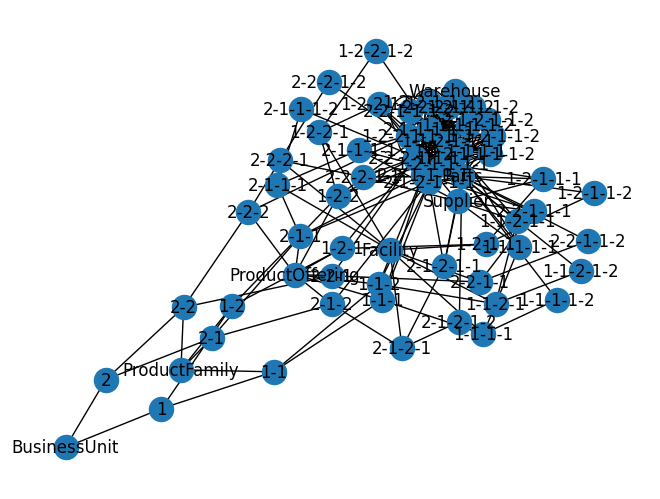

In [43]:
# Convert decompressed graph to networkx graph

decompressed_data = decompress_graph_json(get_schema_data("v1.0", 0))

G = nx.from_dict_of_lists(decompressed_data["nodes"])

# Including edges
# Ensure links are in the correct format: (source, target, {attributes})
edges = [(link['source'], link['target'], link) for link in decompressed_data["links"]]
G.add_edges_from(edges)
nx.draw(G, with_labels=True)
plt.show()

In [44]:
# Basic network analysis

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

print(f"Number of connected components: {nx.number_connected_components(G)}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes()}")

print(f"Number of nodes in the largest connected component: {max(nx.connected_components(G), key=len)}")
print(f"Average clustering coefficient: {nx.average_clustering(G)}")

Number of nodes: 61
Number of edges: 227
Number of connected components: 1
Average degree: 7.442622950819672
Number of nodes in the largest connected component: {'1', '1-2-2-1-2', '2-1-1-1-1', '2-2-2-1-1-1', '2-2-1-1-1', '1-2-2-1', '1-1-2-1-2', '2-2-2-1-1', '2-1-2-1-1-1', '1-2-1-1-2', '2-1-1-1-2', '2-2-1-1', '1-2', '2', '1-2-1-1-1-2', '2-1-2-1-1', 'ProductOffering', '2-1-2-1-1-2', '1-2-1', '1-2-2-1-1', '2-2-1-1-2', '1-2-2-1-1-1', '1-2-1-1', '1-2-1-1-1', '2-2', 'BusinessUnit', 'Parts', '1-2-2', '1-2-1-1-1-1', '1-1-1-1-1-2', '1-1-2-1-1', '2-1-1-1-1-1', '1-1-2-1-1-1', '1-1-1-1', '1-1-2', '2-2-1', '2-1-2', '2-1-1-1', '2-1-1', '1-1', '2-1-2-1', '1-1-1-1-1', '2-1-2-1-2', 'Warehouse', '1-2-2-1-1-2', '2-1', '1-1-1-1-1-1', '2-2-1-1-1-2', '1-1-1-1-2', '2-2-2-1-2', '2-2-2', '2-2-2-1', '2-2-1-1-1-1', 'ProductFamily', 'Supplier', '2-2-2-1-1-2', '1-1-1', '1-1-2-1-1-2', '1-1-2-1', '2-1-1-1-1-2', 'Facility'}
Average clustering coefficient: 0.2541193235159112
